# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
TLS_index = 0 # for TLS of interest
dc_flux_index = 0 # for dc line

2024-10-23 10:36:52,587 - qm - INFO     - Starting session: 1aa232a5-8782-4b05-b3a3-6c7b19ac5cfd


In [2]:
Analysis = AnalysisHandle("quam_state_q0.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# Set voltage of flux line to 0 V
machine.dc_flux[1].dc_voltage = 0 + 0E6
machine = Analysis.set_machine(machine)

In [4]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
#Experiment.set_octave.set_clock(machine)

In [5]:
# set to qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [6]:
machine.octaves[0].LO_sources[1].gain = 0

In [7]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Readout

## Time of Flight

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 70.05s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1023\2024-10-23_q0_time_of_flight_2
DC offset to add to I: 0.000060 V
DC offset to add to Q: 0.000267 V
TOF to add: 0.0 ns


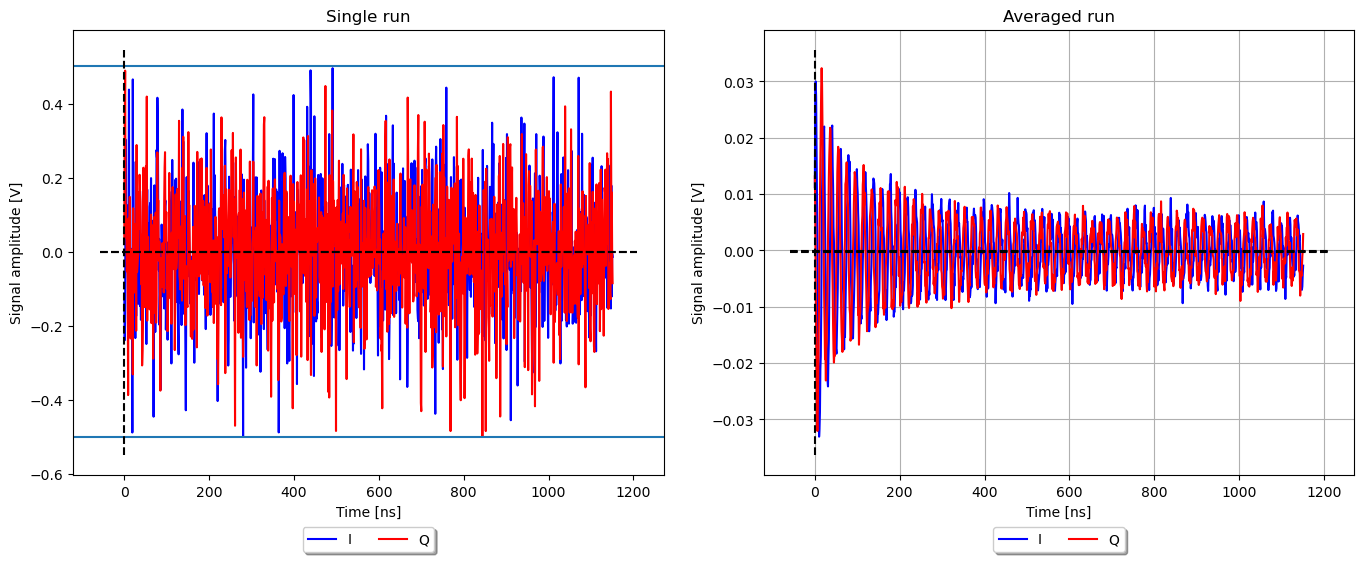

In [3]:
# time_of_flight
# experiment
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.time_of_flight(machine,qubit_index, n_avg = 10E3, cd_time = 10E3, to_simulate = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(expt_dataset)

In [11]:
# update the offset
machine.global_parameters.downconversion_offset_I[0] += dc_offset_i
machine.global_parameters.downconversion_offset_Q[0] += dc_offset_q
machine.resonators[qubit_index].downconversion_offset_I = machine.global_parameters.downconversion_offset_I[0]
machine.resonators[qubit_index].downconversion_offset_Q = machine.global_parameters.downconversion_offset_Q[0]
#machine.resonators[qubit_index].time_of_flight = 304
machine = Analysis.set_machine(machine)

## Resonator spectroscopy

### 1D resonator spectroscopy

In [14]:
machine.resonators[qubit_index].readout_pulse_amp = 0.42

In [20]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq(machine, res_freq_sweep, qubit_index, n_avg = 5E3, cd_time = 10E3, live_plot = True,
                                                    readout_state = 'g', to_simulate = False, data_process_method = 'Amplitude')
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 11.69s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1015\2024-10-15_q0_res_spec_3


resonator frequency: 7262.150 MHz


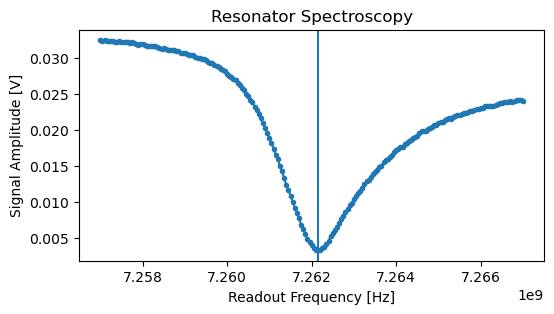

In [22]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(expt_dataset)
machine.resonators[qubit_index].f_readout = res_freq + 0E6

In [23]:
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### 2D resonator spectroscopy

In [15]:
res_freq_sweep = np.arange(7.255E9,7.266E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.1)
%matplotlib qt
machine, expt_dataset = Experiment.exp2D.RR.rr_vs_dc_flux(machine, res_freq_sweep, dc_flux_sweep, qubit_index,
                                                          n_avg = 1E3, cd_time = 10E3, live_plot = True)

Progress: [##################################################] 100.0% (n=181/181) --> elapsed time: 386.74s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1015\2024-10-15_q0_res_spec2D


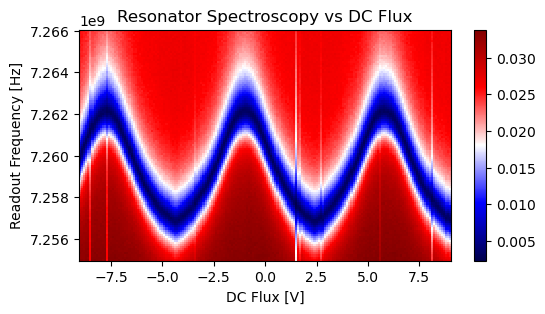

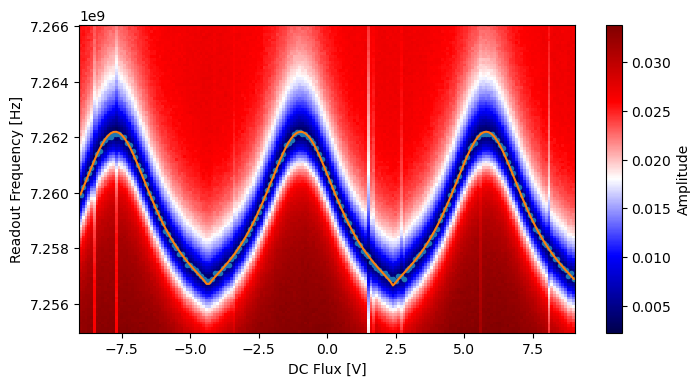

Execution stopped by user!


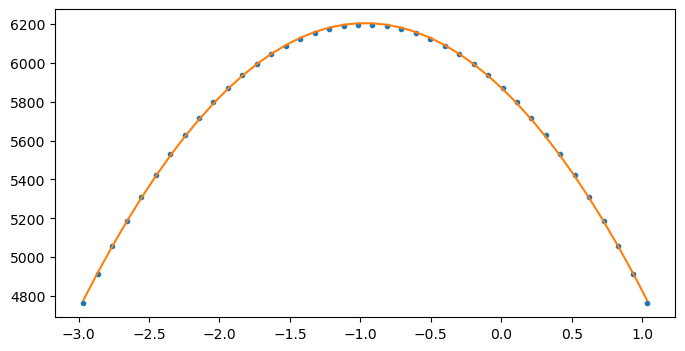

In [16]:
%matplotlib inline 
ham_param = Analysis.exp2D.rr_vs_dc_flux(expt_dataset, to_plot = True, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param = ham_param, to_plot = True)

In [17]:
# save the fitting parameters
machine.resonators[qubit_index].tuning_curve = ham_param
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [18]:
# save the sweep spot flux according to fitted parameter
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param)
machine = Analysis.set_machine(machine)

if 2D res spectroscopy is just to test the experiment, and I want to go back to sweet spot

In [19]:
machine = Analysis.update_machine_res_frequency_sweet_spot(machine, qubit_index, dc_flux_index) 
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50e6
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Sweet Spot Calibrations

## 1D qubit spectroscopy @ sweep spot

In [3]:
if False: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.dc_flux[dc_flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz

qubit_freq_sweep = int(qubit_freq_est) + np.arange(-50E6, 50E6 + 1, 0.5E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True,
                                                         ff_amp = 0.19, n_avg = 1E4, cd_time = 30E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 63.29s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1023\2024-10-23_q0_spec
Execution stopped by user!


peak frequency:  6358.8 [MHz]


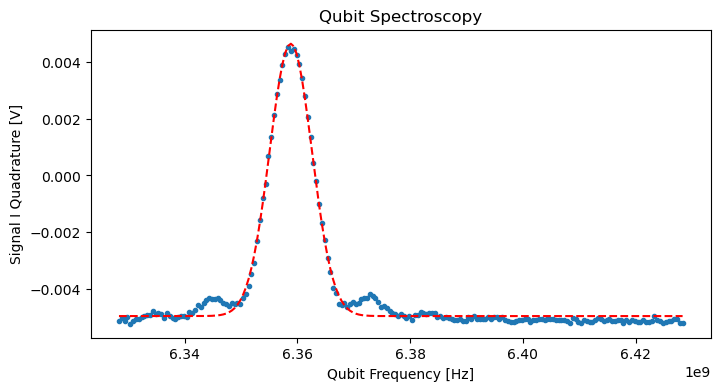

In [4]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6

In [5]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.409 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -49.856 MHz)
------------------------------------- Octave calibration finished.


## Rabi

### Time Rabi

In [12]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 250 + 0.1, 8)  # in ns
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True, 
                                                         ff_amp = 0.19, n_avg = 10E3, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 8.31s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1023\2024-10-23_q0_time_rabi_3


rabi_pi_pulse: 99.4 [ns]
pi period: 98.52 [ns]


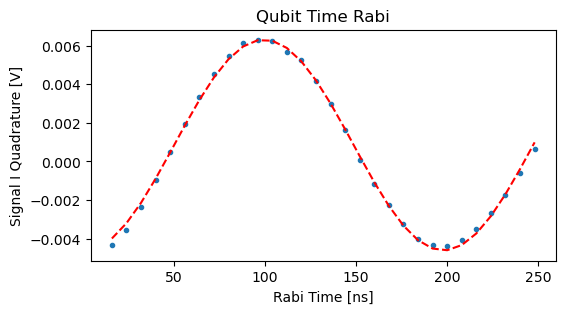

In [14]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", to_plot = True, data_process_method = 'I')

In [11]:
# To get it exact
machine.qubits[qubit_index].pi_amp = machine.qubits[qubit_index].pi_amp*103.4/100
machine = Analysis.set_machine(machine)

In [41]:
machine.qubits[qubit_index].pi_length = 100
machine.qubits[qubit_index].pi_amp = 0.024090757813376554
machine = Analysis.set_machine(machine)

### Power Rabi

In [59]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 2.0, 0.05) 
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, ff_amp = 0.14, live_plot = True,
                                       n_avg = 5E4, cd_time = 20E3, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 41.22s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_power_rabi_4


rabi_pi_amp: 0.024 [V]
pi period: 0.024 [V]


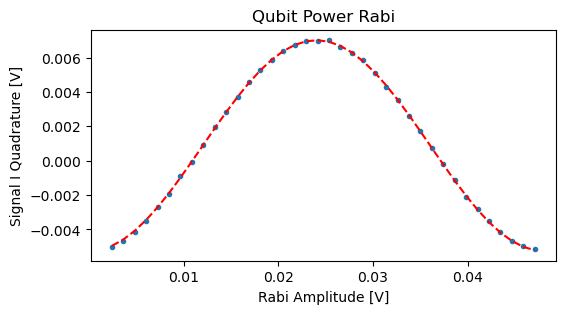

In [61]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')
machine.qubits[qubit_index].pi_amp = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Single-Shot Readout

### Find frequency between g, e

In [52]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-4E6,3E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 1E4, cd_time = 10E3,
                                                    to_simulate = False, simulation_len = 1000, live_plot = True, data_process_method = 'Phase')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 31.44s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1015\2024-10-15_q0_res_spec_ge
Execution stopped by user!


resonator frequency: 7261.600 MHz


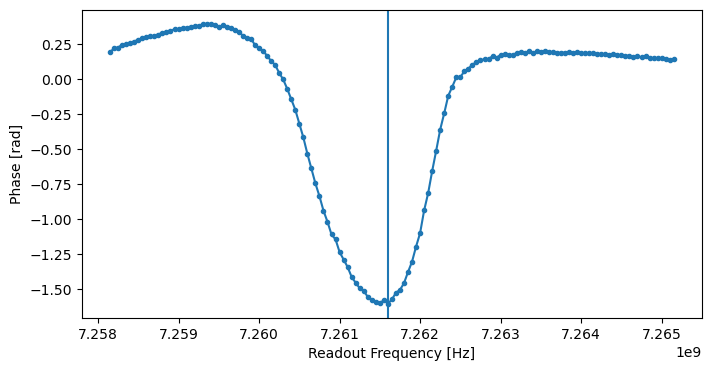

In [53]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [54]:
# doesn't have to update. Use res_freq_phase
# machine.resonators[qubit_index].f_readout = 6226119034 + 0E6
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### IQ blobs

In [85]:
%matplotlib inline
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 25E3, final_plot = False)

----------saved to Z:\QM_Data_DF5\2024\10\Data_1015\2024-10-15_q0_single_shot_IQ_9--> elapsed time: 1.54s



			Fidelity Matrix:
			-----------------
			| 0.958 | 0.042 |
			----------------
			| 0.213 | 0.786 |
			-----------------
			IQ plane rotated by: 359.8°
			Threshold: 2.136e-03
			Fidelity: 87.2%
			


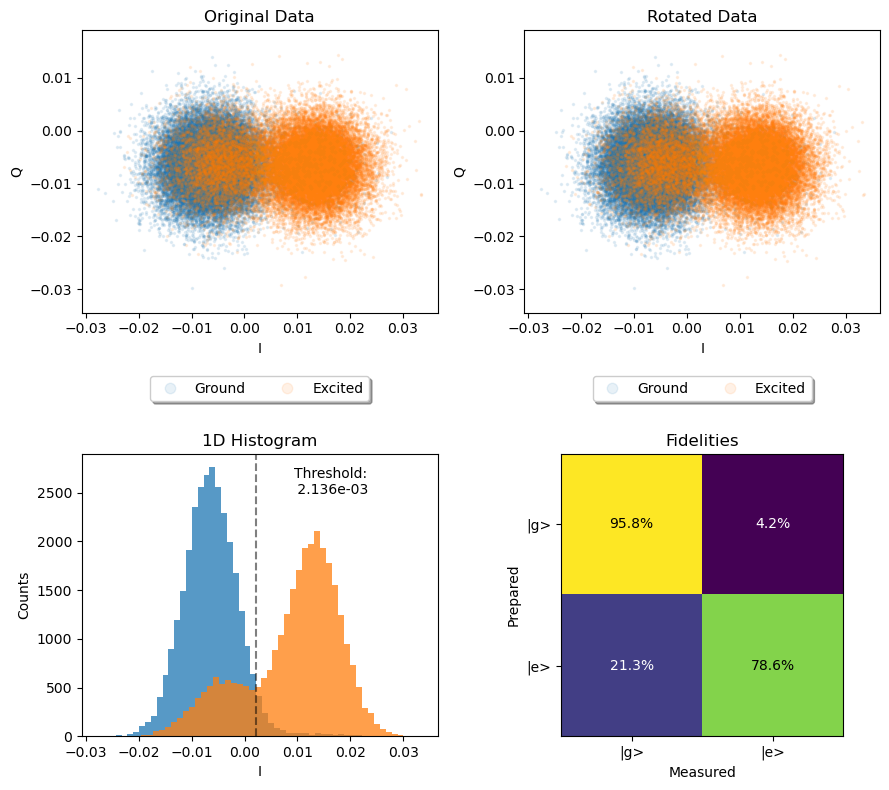

In [86]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [87]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

In [84]:
machine.resonators[qubit_index].readout_pulse_amp = 0.47
machine.resonators[qubit_index].readout_pulse_length = 1152
machine = Analysis.set_machine(machine)

### Readout freq optimization

In [68]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-1.5E6, 1.5E6 + 1, 0.05E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 5E4, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

Execution stopped by user!                                   ] 11.9% (n=5926/50000.0) --> elapsed time: 19.01s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0522\2024-05-22_q4_single_shot_freq.0) --> elapsed time: 19.27s
The optimal readout frequency is 6223722880.0 Hz (SNR=0.048823998479026236)


peak frequency:  6226.2 [MHz]


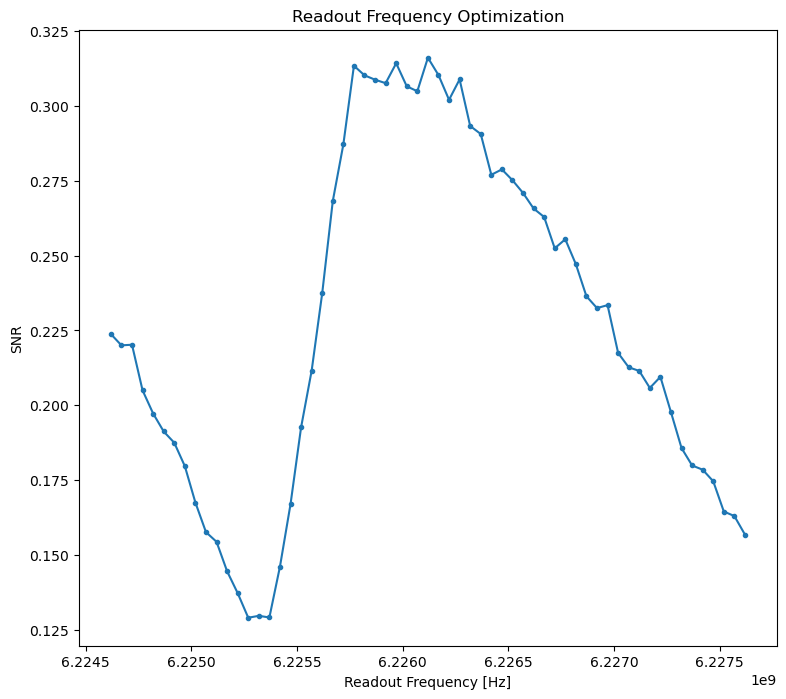

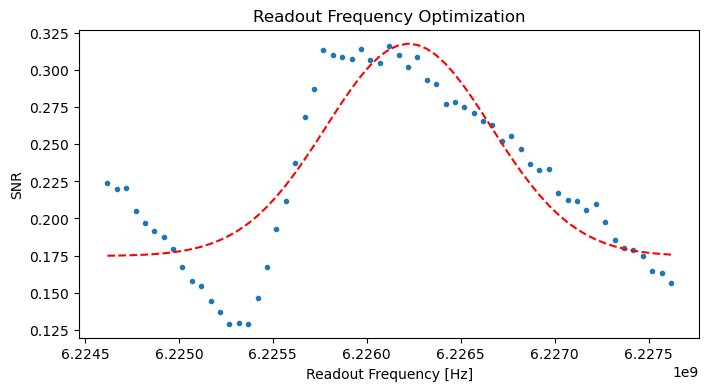

Execution stopped by user!


In [150]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", data_process_method = 'SNR')

In [95]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q4 for (LO, IF) = (5.762 GHz, -50.000 MHz)
------------------------------------- Calibrates r4 for (LO, IF) = (6.274 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### Readout pulse amp and duration (by qubit relaxation during readout)

In [116]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 20)
res_amp_sweep_abs = np.arange(0.15,0.45,0.001)
machine, expt_dataset = Experiment.exp2D.RR.rr_pulse_optimize(machine, res_duration_sweep_abs, res_amp_sweep_abs, qubit_index, n_avg=1E3, 
                                                              cd_time=25E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 744.49s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q4_res_pulse_optimize


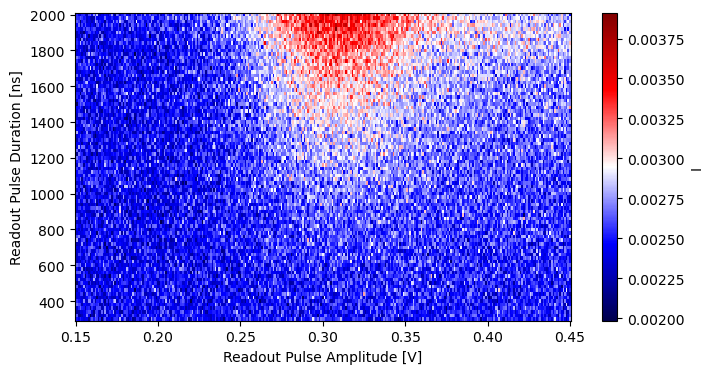

In [126]:
%matplotlib inline
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q4_res_pulse_optimize.nc")
data['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [69]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine.resonators[qubit_index].readout_pulse_length =1396
machine = Analysis.set_machine(machine)

### Readout duration optimization

In [67]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 2E4, cd_time = 25E3)

Integration weights chunk-size length in ns: 40
The readout has been sliced in the following number of divisions 50
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.72s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.73s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.75s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.77s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.78s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.80s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.81s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed 

In [102]:
machine.resonators[qubit_index].readout_pulse_length = 1360
machine = Analysis.set_machine(machine)

### Readout amp optimization

In [ ]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

peak voltage:  0.511 [V]


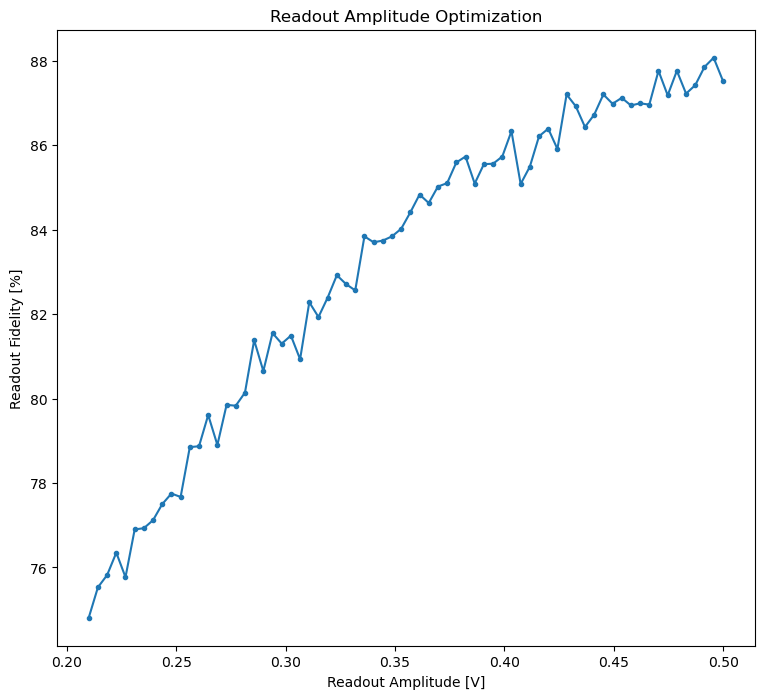

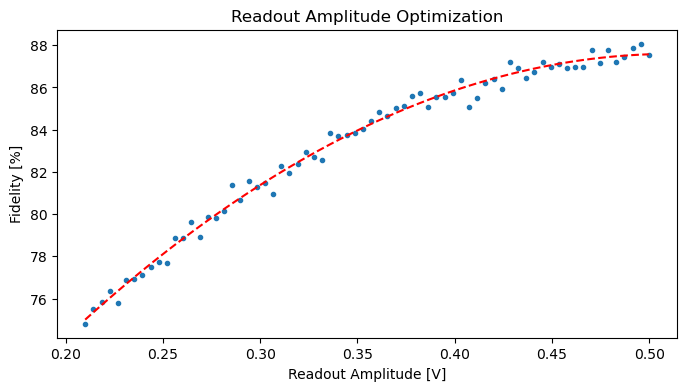

In [104]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Fidelity')

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.48
machine = Analysis.set_machine(machine)

## Qubit T1

In [15]:
%matplotlib qt
tau_sweep_abs = np.arange(100,50E3+1,1E3)
machine, expt_dataset = Experiment.exp1D.T1.qubit_T1(machine, tau_sweep_abs, qubit_index, ff_amp = 0.19, n_avg = 1E4, cd_time = 50E3, live_plot = True,
                                                               to_simulate = False, simulation_len = 15_000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 38.07s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1023\2024-10-23_q0_T1


Qubit T1: 5.3 [us]


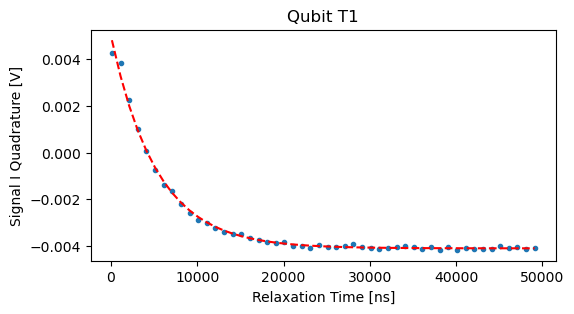

In [17]:
%matplotlib inline
qubit_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T1 = qubit_T1
machine = Analysis.set_machine(machine)

## Qubit Ramsey

In [27]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 25000 + 0.1, 24)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.ramsey(machine, ramsey_duration_sweep, qubit_index, detuning = 2E6, live_plot = True,
                                                       ff_amp = 0.19, n_avg = 2E4, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

Execution stopped by user!                                   ] 2.9% (n=584/20000.0) --> elapsed time: 23.49s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1023\2024-10-23_q0_ramsey_1020000.0) --> elapsed time: 24.11s


Qubit T2*:  2283.5 [ns]
Exponent n =  6.0
Detuning =  0.0 [MHz]


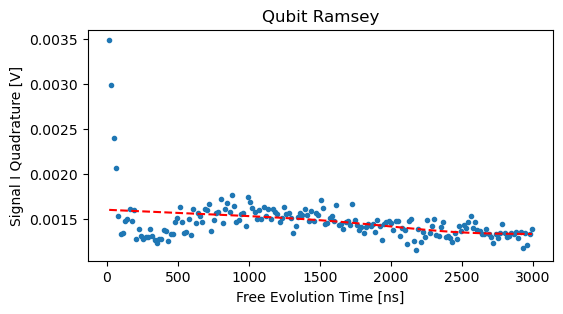

In [72]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T2 = q_T2star
machine = Analysis.set_machine(machine)

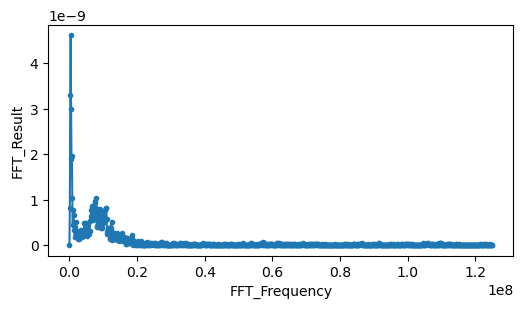

In [57]:
%matplotlib inline
fft_dataset = Analysis.exp1D.fft(expt_dataset, to_plot = True, data_process_method = 'I')

In [53]:
# Get the peak frequency
idx = fft_dataset['FFT_Result'].argmax().item()
max_freq = fft_dataset['FFT_Frequency'][idx].item()
max_freq

857843.1372549019

In [92]:
 2E6 - max_freq

-5870.84148727986

In [87]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_01 + 189823
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)
machine = Experiment.set_octave.calibration(machine, qubit_index)


------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-190E6, -150E6 + 1, 0.5E6) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_freq(machine, ef_freq_sweep, qubit_index, pi_amp_rel_ef = 1.0, n_avg = 2E3, live_plot = True,
                                                      cd_time = 30E3, readout_state = 'g', to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - ef_freq
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel_ef = 1.0, live_plot = True,
                                                                             n_avg = 2E3, cd_time = 30E3, readout_state = 'g', 
                                                                             to_simulate = False, simulation_len = 10_000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_length_ef = 180
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, n_avg = 2E3, cd_time = 30E3, live_plot = True,
                                                          readout_state = 'g', to_simulate = False, simulation_len = 1000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_amp_ef = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Qubit DD

### Echo

In [ ]:
tau_sweep_abs = np.arange(16, 32E3 + 0.1, 20)  # in units of ns
n_avg = 5E3 # Number of total averages
delta_avg = 1000 # After this amount of averages run a TLS spectroscopy to make sure the signal has not decayed
cd_time_qubit = 25E3
runs = int(n_avg/delta_avg)

## In order to save the averaged data
expt_qubits = [machine.qubits[qubit_index].name]
expt_extra = [ 'n_ave: ' + str(n_avg) + '-' + 'Qubit CD [ns]: ' + str(cd_time_qubit) ] # ALWAYS SEPARATE DIFFERENT ATTRIBUTES WITH A DASH (this is the delimiter)
expt_sequence = """update_frequency(machine.qubits[qubit_index].name, tls_if_freq) # important, otherwise will use the if in configuration, calculated from f_01
with for_(n, 0, n < n_avg, n + 1):
	with for_(*from_array(t, tau_sweep)):
		with strict_timing_():
			if pi_over_2_phase=='x':
				play("pi2_tls", machine.qubits[qubit_index].name)
			else:
				play("pi2y_tls", machine.qubits[qubit_index].name)

			wait(t, machine.qubits[qubit_index].name)

			for i in range(N_CPMG - 1):
				play("pi_tls", machine.qubits[qubit_index].name)
				wait(t * 2, machine.qubits[qubit_index].name)

			play("pi_tls", machine.qubits[qubit_index].name)
			wait(t, machine.qubits[qubit_index].name)

			if pi_over_2_phase=='x':
				play("pi2_tls", machine.qubits[qubit_index].name)
			else:
				play("pi2y_tls", machine.qubits[qubit_index].name)

		align()
		square_TLS_swap[0].run()
		align()
		readout_rotated_macro(machine.resonators[qubit_index].name,I,Q)
		wait(cd_time_qubit * u.ns, machine.resonators[qubit_index].name)
		save(I, I_st)
		save(Q, Q_st)
		align()
		square_TLS_swap[0].run(amp_array=[(machine.flux_lines[qubit_index].name, -1)])
		wait(cd_time_TLS * u.ns, machine.flux_lines[qubit_index].name)
	save(n, n_st)
 NOTE: THE AVERAGES ARE DONE SEQUENTIALLY TO UPDATE THE TLS FREQUENCY IN CASE IT CHANGED"""



for ind, N in enumerate(N_CPMG_sweep):
    N = int(N)
    datasets = []
    print('*****************RUNNING CPMG ', N , '*****************')
    timestamp_created = datetime.datetime.now()
    
    for n in np.arange(runs):
        print('Running average', n+1, 'out of ', runs)
        machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N,
                         n_avg = delta_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False, live_plot = False)
        datasets.append(expt_dataset)
        
        # Run spectroscopy
        print('Running spectroscopy', n+1, 'out of ', runs)
        TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-13E6,13E6+1,1E6)
        machine, expt_dataset_spec = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                          n_avg = 2E3, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, final_plot = False, live_plot = False, data_process_method = 'I')
        
        # Analyze spectrosocpy data to get the newest frequency 
        TLS_freq = Analysis.exp1D.peak_fit(expt_dataset_spec, to_plot= False,  method = "Gaussian", data_process_method = 'I')
        machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
        machine = Analysis.set_machine(machine)
        print('Set TLS frequency to', TLS_freq)
        
    dataset_tmp = xr.concat(datasets, dim='runs')
    dataset_ave = dataset_tmp.mean(dim='runs')
    timestamp_finished = datetime.datetime.now()
    expt_name = 'tls_cpmg' + str(N_CPMG_sweep[ind])
    expt_long_name = 'TLS CPMG' + '-' + str(N_CPMG_sweep[ind])
    # save data
    expt_dataset = Experiment.datalogs.save(dataset_ave, machine, timestamp_created, timestamp_finished, expt_name, expt_long_name, expt_qubits, expt_TLS, expt_sequence, expt_extra = expt_extra)
    globals()[f'exp_dataset_CPMG_{N}'] = expt_dataset

In [73]:
%matplotlib qt
tau_sweep_abs = np.arange(16, 18E3 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.qubit_echo(machine, tau_sweep_abs, qubit_index, ff_amp = 0.14, n_avg = 10E3,
                     cd_time_qubit = 25E3, live_plot = True, data_process_method = 'I')		

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 414.50s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_qubit_echo


Qubit T2*:  1.6 [us]
Exponent n =  2.3


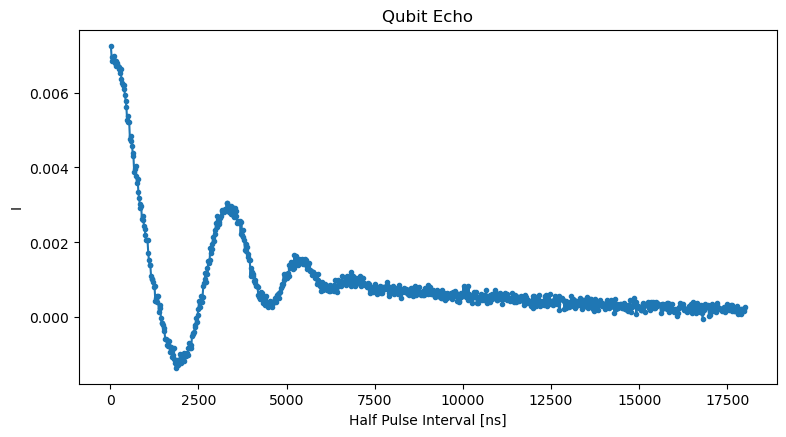

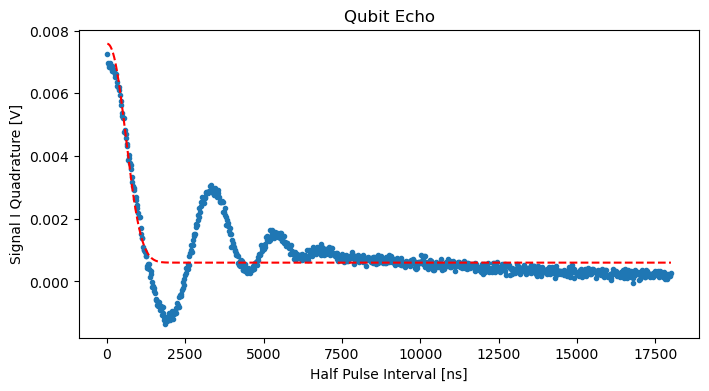

Execution stopped by user!


In [74]:
%matplotlib inline
Qubit_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau =2)

### CPMG

In [75]:
%matplotlib qt
N_CPMG = np.arange(2,21,2)
tau_sweep_abs = np.arange(500, 18E3 + 0.1, 20)  # in units of ns
for i in N_CPMG:    
    machine, expt_dataset = Experiment.exp1D.DD.qubit_CPMG(machine, tau_sweep_abs, qubit_index,  ff_amp = 0.14, N_CPMG = int(i),
                         n_avg = 10E3, cd_time_qubit = 25E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 692.21s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 692.78s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_qubit_cpmg2
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1323.34s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_qubit_cpmg4
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1968.70s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_qubit_cpmg6
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 2616.63s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1022\2024-10-22_q0_qubit_cpmg8
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3267.06s


# Qubit Tuning Curves

## 2D qubit spectroscopy vs dc flux

In [117]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.dc_flux[dc_flux_index].max_frequency_point + np.arange(-0.5,0.5+1E-4,0.02)
qubit_if_sweep = np.arange(-30E6, 30E6, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(machine, dc_flux_sweep, qubit_if_sweep, qubit_index,
                                 n_avg = 1E3, cd_time = 25E3, final_plot = True, live_plot = True,  data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=51/51) --> elapsed time: 626.03s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1016\2024-10-16_q0_res_spec_vs_dc_flux_5
----------saved to Z:\QM_Data_DF5\2024\10\Data_1016\2024-10-16_q0_qubit_spec_vs_dc_flux_5


In [118]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 2, to_plot = False, data_process_method = 'Amplitude')
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param) + 0E1
print(f"sweet spot flux: {machine.dc_flux[dc_flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.96077 V


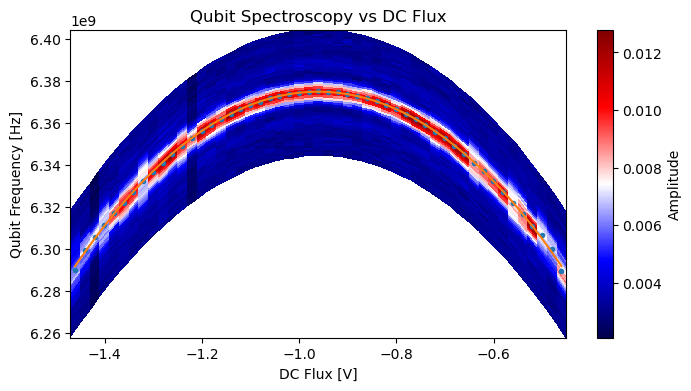

In [120]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'Amplitude')
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [121]:
# go to the sweet spot, if needed
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

In [122]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.425 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -49.856 MHz)
------------------------------------- Octave calibration finished.


## 2D qubit spectroscopy vs fast flux

In [123]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [124]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
      qubit_index, ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 25E3)

------------------------------------- Octave calibration starts...7% (n=4/6) --> elapsed time: 24.22s
------------------------------------- Calibrates q0 for (LO, IF) = (5.801 GHz,  290.000 MHz)
------------------------------------- Octave calibration finished.
Progress: [##################################################] 100.0% (n=6/6) --> elapsed time: 45.43s
----------saved to Z:\QM_Data_DF5\2024\10\Data_1016\2024-10-16_q0_qubit_spec_vs_fast_flux


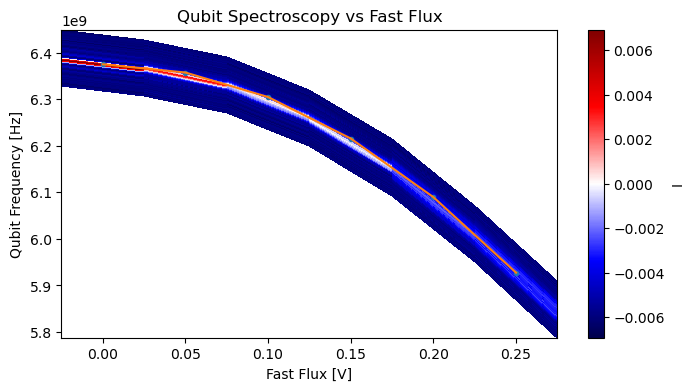

In [126]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

### fast version, runs blockwise 2D sweeps

In [136]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.7E9, -5E6)
qubit_if_sweep = np.arange(-160E6, 60E6 + 1, 0.5E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(machine, qubit_freq_sweep,qubit_if_sweep,
          qubit_index, n_avg = 4E3, cd_time = 25E3, final_plot = True, live_plot = True)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.076 GHz,  200.000 MHz)
------------------------------------- Octave calibration finished.
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1872.35s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1872.35s
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (5.876 GHz,  200.000 MHz)
------------------------------------- Octave calibration finished.
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1872.25s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1871.91s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elap

In [137]:
%matplotlib qt
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\10\Data_1016\2024-10-16_q0_qubit_spec_vs_fast_flux_6.nc")
data['I'].plot(x = list(data.coords.keys())[0], y = list(data.coords.keys())[1], cmap = "seismic")

In [138]:
# save the fitted tuning curve
# %matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

# TLS experiments

## TLS SWAP spectroscopy

In [54]:
machine.octaves[0].LO_sources[1].LO_frequency-machine.qubits[qubit_index].f_01

50000000.0

In [141]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [142]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.428 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -49.856 MHz)
------------------------------------- Octave calibration finished.


### coarse, no baking

In [19]:
%matplotlib qt
tau_sweep_abs = np.arange(16,100 + 0.1,1)
# ff_sweep_abs = np.arange(0.25,0.32,0.002)
ff_sweep_abs = np.arange(0.1,0.5,0.002)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_coarse(machine, tau_sweep_abs, ff_sweep_abs, qubit_index, 
                      n_avg = 5E3, cd_time = 25E3, live_plot=True)

Execution stopped by user!                                   ] 26.9% (n=1343/5000.0) --> elapsed time: 301.09s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0918\2024-09-18_q0_swap2D1345/5000.0) --> elapsed time: 302.39s


### fine, with baking

In [20]:
%matplotlib qt
tau_sweep_abs = np.arange(4,160,1)
# ff_sweep_abs = np.arange(0.1,0.45+1E-4,0.002)
ff_sweep_abs = np.arange(0.35,0.46,0.0005)
machine, expt_dataset = Experiment.exp2D.SWAP.swap(machine, tau_sweep_abs, ff_sweep_abs, qubit_index,
                      n_avg = 4E3, cd_time = 25E3, live_plot=True)

Execution stopped by user!#####                              ] 41.1% (n=1645/4000.0) --> elapsed time: 2896.89s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0918\2024-09-18_q0_swap2D_246/4000.0) --> elapsed time: 2897.41s


In [21]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [22]:
fft_dataset = Analysis.exp2D.SWAP_fft(expt_dataset, to_plot = True)

### Add TLS iswap params

In [43]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0522\2024-05-22_q4_swap2D_4.nc")

SWAP plot, to find the SWAP param range for different TLS

In [37]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")
plt.show()

initialize the iswap params in quam

In [23]:
machine.flux_lines[qubit_index].iswap.length =[]
machine.flux_lines[qubit_index].iswap.level = []

#### TLS0

In [26]:
flux_min, flux_max = (0.40,0.42)
interaction_time_min, interaction_time_max = (4,12)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.41050 [V]
iswap flux length:  7 [ns]


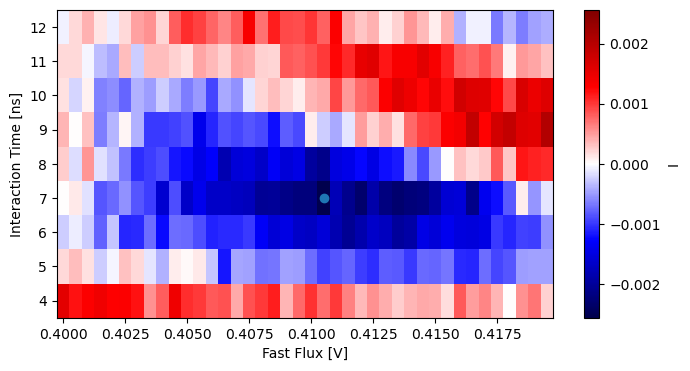

In [27]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [28]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS1

In [30]:
flux_min, flux_max = (0.387,0.405)
interaction_time_min, interaction_time_max = (10, 18)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.40200 [V]
iswap flux length:  16 [ns]


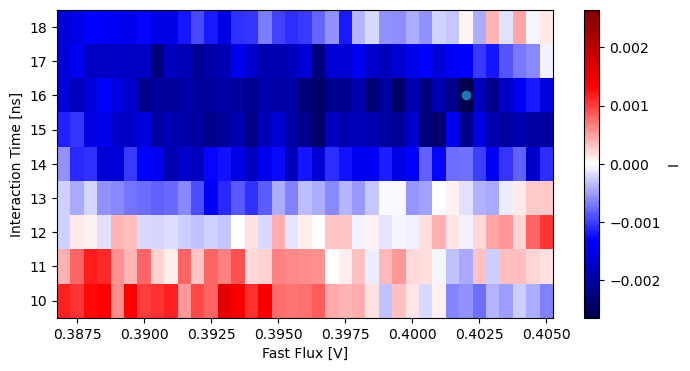

In [31]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [32]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS2

In [34]:
flux_min, flux_max = (0.376,0.386)
interaction_time_min, interaction_time_max = (16,24)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.37950 [V]
iswap flux length:  20 [ns]


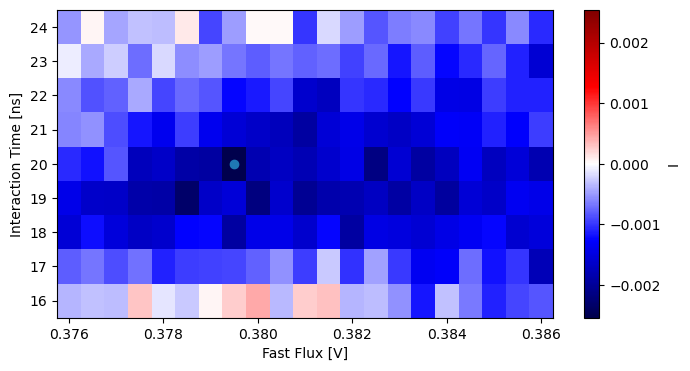

In [35]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [36]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

### TLS3

In [38]:
flux_min, flux_max = (0.44,0.452)
interaction_time_min, interaction_time_max = (16,26)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.44400 [V]
iswap flux length:  21 [ns]


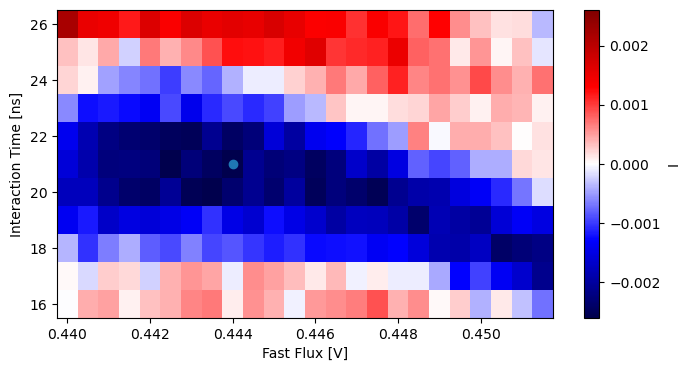

In [39]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [40]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

### estiguess of the TLS frequency, based on iswap flux level

In [41]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level[0])
freq_tls

5114.876868261843

In [42]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level)
machine.qubits[qubit_index].f_tls = (np.floor(freq_tls*1E6)).tolist()    
machine = Analysis.set_machine(machine)

initialize pi_length_tls, pi_amp_tls

In [44]:
machine.qubits[qubit_index].pi_length_tls = [200] * len(machine.flux_lines[qubit_index].iswap.length)
machine.qubits[qubit_index].pi_amp_tls = [0.45] * len(machine.flux_lines[qubit_index].iswap.length)
machine = Analysis.set_machine(machine)